In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
print(sys.path)
from eigenwell.src import grid, eigen_k, eigen_w, structure, pec_pmc
from eigenwell.src.constants import *

from scipy.sparse.linalg import splu
import scipy.sparse.linalg as la

['/Users/nathanzhao/src/eigenwell/notebooks', '/Users/nathanzhao/src', '/Users/nathanzhao/opt/anaconda3/lib/python38.zip', '/Users/nathanzhao/opt/anaconda3/lib/python3.8', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/lib-dynload', '', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/aeosa', '/Users/nathanzhao/src/ceviche', '/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/IPython/extensions', '/Users/nathanzhao/.ipython']


(80, 80)
(6400, 6400) [1.25e-08 1.25e-08]
[1.25e-08 1.25e-08] [1.25e-08 1.25e-08]


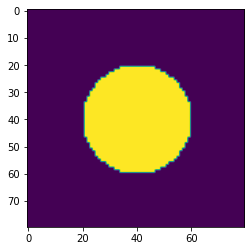

In [2]:
Nx = 80;
Ny = 80;
N = np.array([Nx, Ny]);

eps_r = np.ones(N);

a = np.array([1,1])*1e-6;
dL = a/N;
radius = 0.25*1e-6;
## put in a circle;
ci = int(Nx/2); cj= int(Ny/2);

cr = (radius/a[0])*Nx;
I,J=np.meshgrid(np.arange(eps_r.shape[0]),np.arange(eps_r.shape[1]));

print(eps_r.shape)
dist = np.sqrt((I-ci)**2 + (J-cj)**2);
#print(np.where(dist<cr))
eps_r[np.where(dist<cr)] = 6;

plt.imshow(eps_r)

fd = grid.FiniteDifferenceGrid(dL,N)

print(fd.Dxf.shape, dL)

st = structure.Structure(eps_r, a);
print(st.dL, dL)

In [3]:
eigen2d = eigen_w.EigenOmega2D(st);
A = eigen2d.A;

wvlen = 1e-6;
omega = 2*np.pi*C0/(wvlen);

eigvals, eigvecs = la.eigs(A, sigma = omega**2, k = 10)

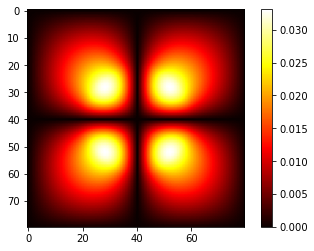

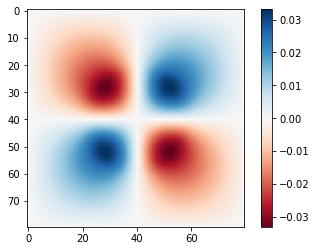

In [4]:
plt.imshow(np.abs(eigvecs[:,0].reshape(N)), cmap = 'hot')
plt.colorbar();
plt.show();
plt.imshow(np.real(eigvecs[:,0].reshape(N)), cmap = 'RdBu')
plt.colorbar();

## Photonic Band Structure
#### Ky = 0

In [16]:
from scipy.sparse.linalg import splu
wvlen = 1e-6;
omega = 2*np.pi*C0/wvlen;
eigk = eigen_k.EigenK2D(st, polarization = 'TE')
eigk.make_operator_components(omega);
print(fd.Dxf.shape)
OA = eigk.OA;
OB = eigk.OB;
# plt.figure(figsize = (10,10));
# plt.spy(OB, markersize = 0.5);

B = splu(OA-OB)
print(B.L.count_nonzero())



(6400, 6400)
683589


/Users/nathanzhao/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


In [17]:
eigvals, eigvecs = la.eigs(OA, k = 10, M = OB, sigma= 0)
print(eigvals)

[-1.48244839e+06-1.05474588e-02j  1.48244839e+06-1.03504337e-02j
 -7.98152259e-03+1.61689694e+06j -2.81054049e-03-1.61689690e+06j
  3.14613499e+06-1.29342763e+06j  3.14613498e+06+1.29342763e+06j
 -3.14613499e+06+1.29342764e+06j -3.14613500e+06-1.29342763e+06j
  4.79378169e+06+4.77535485e-03j -4.79378169e+06-5.29411839e-03j]


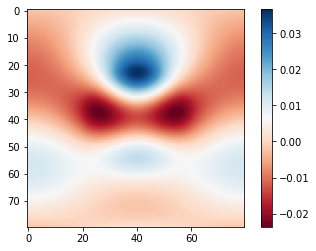

In [22]:
plt.imshow(np.real(np.reshape(eigvecs[0:np.prod(N),5], N, order = 'F')), cmap = 'RdBu')
#plt.imshow(np.real(np.reshape(eigvecs[np.prod(N):,4], N, order = 'F')), cmap = 'RdBu')

plt.colorbar();

In [23]:
#wvlen_scan = np.linspace(1,10,60);
wvlen_scan = np.logspace(np.log10(1), np.log10(5),100)*1e-6
spectra = [];
for c,wvlen in enumerate(wvlen_scan):
    omega = 2*np.pi*C0/(wvlen);
    
    #eigvals, eigvecs = eigk.eigensolve(omega, Ky, num_modes = 10)
    eigk.make_operator_components(omega);
    OA = eigk.OA;
    OB = eigk.OB;
    
    eigvals, eigvecs = la.eigs(OA, k = 10, M = OB, sigma= 0)

    
    spectra.append(eigvals);
    if(c%20 == 0):
        print(c, wvlen)
spectra = np.array(spectra)

0 1e-06
20 1.3842230011425227e-06
40 1.916073316892012e-06
60 2.6522727571173693e-06


KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (79, 10) and (100,)

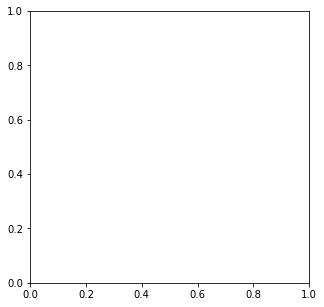

In [24]:
plt.figure(figsize = (5,5));
plt.plot(np.real(spectra), 1/wvlen_scan, '.b', markersize = 2);
plt.plot(np.imag(spectra),  1/wvlen_scan, '.r', markersize = 2);
#plt.xlim((-30e6, 50e6))
plt.ylim(0,1)
plt.show();


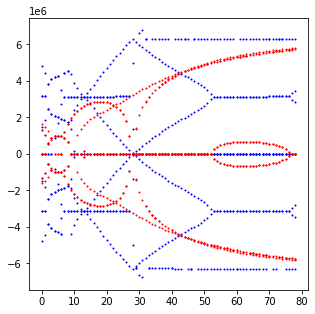

In [26]:

plt.figure(figsize = (5,5));
plt.plot(np.real(spectra), '.b', markersize = 2);
plt.plot(np.imag(spectra), '.r', markersize = 2);

## TM Scan